In [1]:
import numpy  as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt

from ic_course_utils import replace_tag
from ic_course_utils import find_pmap_with_s1_s2

%matplotlib inline

In [2]:
input_file = "data/Kr83_highstat.sophronia.h5"

# Input file structure

The input file contains a table at `/RECO/Events` that holds a hit collection for each event.
Each row contains a single hit.

The table contains the following columns:
- event: event number
- time: timestamp of the event in s
- npeak: index of the S2 peak within the event
- Xpeak: global X position of the S2 peak
- Ypeak: global Y position of the S2 peak
- nsipm: number of sipms with signal (always 1, will be dropped in the future)
- X, Y: x-y position of the SiPM
- Xrms, Yrms: always NaN (will be dropped in the future)
- Z: drift distance in mm
- Q: SiPM charge in pes
- E: corresponding fraction of the slice energy calculated as $\frac{Q_i}{\sum Q_i}$ 
- Q: corrected SiPM charge (deprecated, may be removed in the future)
- E: corrected hit energy
- track_id: deprecated (will be removed in the future)
- Ep: deprecated (will be removed in the future)

In [3]:
!ptdump -v $input_file:/RECO/Events

/RECO/Events (Table(2506,)shuffle, zlib(4)) 'Hits'
  description := {
  "event": Int64Col(shape=(), dflt=0, pos=0),
  "time": Float64Col(shape=(), dflt=0.0, pos=1),
  "npeak": UInt16Col(shape=(), dflt=0, pos=2),
  "Xpeak": Float64Col(shape=(), dflt=0.0, pos=3),
  "Ypeak": Float64Col(shape=(), dflt=0.0, pos=4),
  "nsipm": UInt16Col(shape=(), dflt=0, pos=5),
  "X": Float64Col(shape=(), dflt=0.0, pos=6),
  "Y": Float64Col(shape=(), dflt=0.0, pos=7),
  "Xrms": Float64Col(shape=(), dflt=0.0, pos=8),
  "Yrms": Float64Col(shape=(), dflt=0.0, pos=9),
  "Z": Float64Col(shape=(), dflt=0.0, pos=10),
  "Q": Float64Col(shape=(), dflt=0.0, pos=11),
  "E": Float64Col(shape=(), dflt=0.0, pos=12),
  "Qc": Float64Col(shape=(), dflt=0.0, pos=13),
  "Ec": Float64Col(shape=(), dflt=0.0, pos=14),
  "track_id": Int32Col(shape=(), dflt=0, pos=15),
  "Ep": Float64Col(shape=(), dflt=0.0, pos=16)}
  byteorder := 'little'
  chunkshape := (546,)
  autoindex := True
  colindexes := {
    "event": Index(6, mediumshu

# Input file data visualization

hDSTs are read directly as pandas DataFrames:

In [4]:
dst = pd.read_hdf(input_file, "/RECO/Events")
dst

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,0,1.577742e+06,0,199.979265,-19.979265,1,195.0,-15.0,0.0,0.0,383.850094,13.235277,1621.694513,-1.0,-1.0,-1,-1.0
1,0,1.577742e+06,0,199.979265,-19.979265,1,205.0,-25.0,0.0,0.0,383.850094,13.125956,1608.299536,-1.0,-1.0,-1,-1.0
2,13,3.873856e+06,0,-50.252283,170.252283,1,-55.0,175.0,0.0,0.0,440.249313,18.114822,1833.189907,-1.0,-1.0,-1,-1.0
3,13,3.873856e+06,0,-50.252283,170.252283,1,-45.0,165.0,0.0,0.0,440.249313,16.374601,1657.082432,-1.0,-1.0,-1,-1.0
4,26,4.118460e+06,0,125.000000,-68.369138,1,125.0,-75.0,0.0,0.0,264.326656,14.430882,1328.076231,-1.0,-1.0,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2501,12961,1.994488e+09,0,-62.087490,-44.145477,1,-65.0,-35.0,0.0,0.0,80.904094,24.843456,945.928154,-1.0,-1.0,-1,-1.0
2502,12961,1.994488e+09,0,-62.087490,-44.145477,1,-55.0,-55.0,0.0,0.0,80.904094,16.046423,610.976310,-1.0,-1.0,-1,-1.0
2503,12961,1.994488e+09,0,-62.087490,-44.145477,1,-55.0,-45.0,0.0,0.0,80.904094,13.936926,530.656058,-1.0,-1.0,-1,-1.0
2504,12974,1.997863e+09,0,32.023618,155.000000,1,25.0,155.0,0.0,0.0,456.568625,10.622196,1105.833163,-1.0,-1.0,-1,-1.0


hDSTs with Kr are not very interesting. For a more interesting output see the last section in the Sophronia notebook.

In [5]:
from invisible_cities.reco.xy_algorithms import barycenter

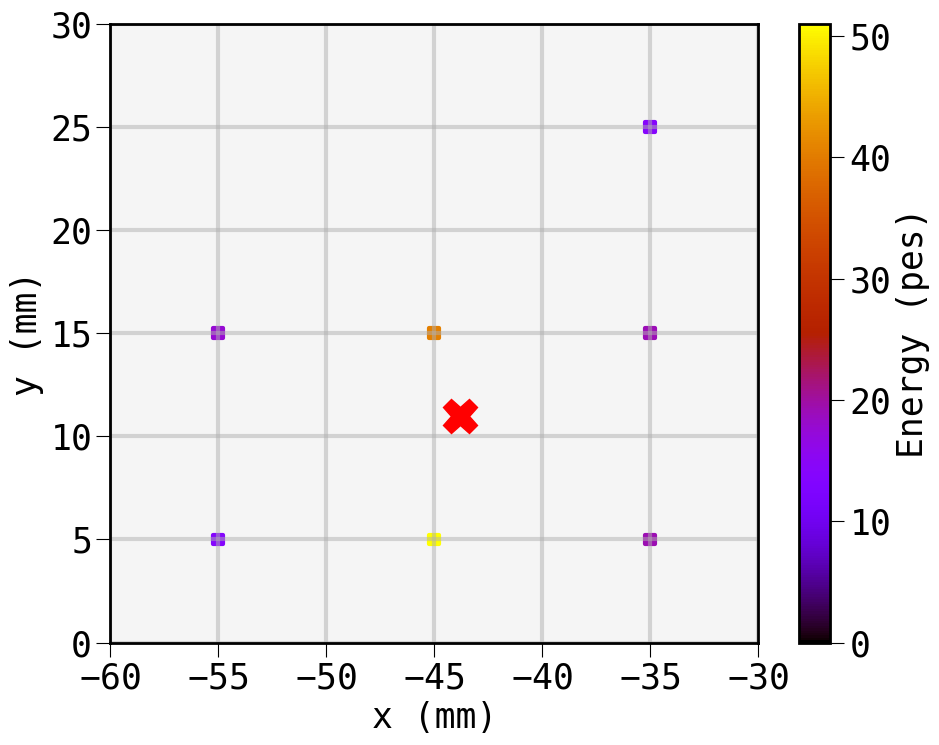

In [6]:
event = dst.groupby("event").count().time.idxmax() # find event with greatest number of hits
peak  = 0
hits  = dst.loc[lambda df: (df.event == event) & (df.npeak == peak)]

x0, y0 = barycenter(hits.filter("X Y".split()).values, hits.Q.values)[0].XY

plt.figure(figsize=(10,8))
plt.scatter(hits.X, hits.Y, marker="s", s=50, c=hits.Q, vmin=0)
plt.plot([x0], [y0], marker="X", c="r")
plt.gca().set_facecolor("whitesmoke")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.xlim(hits.X.min() - 5, hits.X.max() + 5)
plt.ylim(hits.Y.min() - 5, hits.Y.max() + 5)
plt.colorbar().set_label("Energy (pes)")

# Eutropia

## Description

Produces a Point Spread Function (PSF) from Kr data.

This city reads hDSTs produced by Sophronia and produces PSFs. The input data to this city must be produced using a special Sophronia configuration with low `q_thr` and high `rebin` (\*). An example of this configuration file can be found in `data/sophronia_for_psf.conf`.

The PSF is obtained by mapping the spatial charge distribution relative to the barycenter (center of gravity of SiPM response). This charge distribution is averaged over a large number of events. The PSF can be obtained for different sections of the active volume independently.
The steps performed by Eutropia can be summarized in the following tasks:
  - Split events in xy-sections and z-slices. Each section-slice will apply the following transformations independently
    - Normalize the charge distribution in each event
    - Transform absolute hit position to relative positions to the barycenter of each event
    - Create a 2d charge profile using relative coordinates by averaging multiple events

Each charge profile constitutes a PSF and they are combined into a single object (the overall PSF). A collection of PSFs can be combined into a single PSF using an external tool (\*\*).

The overall PSF is described by the coordinates of the center of each xy-sector and z-slice (x, y, z). Each triplet of values is a PSF. Each PSF is a matrix where each element is described by the relative position to the barycenter (xr, yr), by the PSF factor (fraction of charge in the 2d charge profile) and the number of events contributing to the matrix element.

(\*) These values achieve two things: the low charge threshold keeps hits far away from the interaction point that have lower signal. The rebin parameter collapses the event in Z, integrating the time response.

(\*\*) This tool is not included in IC at the moment, but it can be found in https://gist.github.com/gonzaponte/5af3ff1176eba8b16d0e5e45c6bc59ed.

More details will be found in the official documentation:
https://next-exp-sw.readthedocs.io/en/latest/eutropia.html
.

## Parameters

| Parameter | Type  | Description |
|:--------:|:--------:|:--------:|
| `xrange, yrange` | `Sequence[float]` | Range for the 2d charge profile in each axis |
| `zbins` | `Sequence[float]` | Bin edges for the z-slices the data is split into |
| `xsectors, ysectors` | `Sequence[float]` | Bin edges for the xy-sectors the data is split into |
| `bin_size_xy` | `float` | Bin size of the charge profile (PSF) |

## Configuration

An Eutropia configuration file for NEW data. This file does not produce a detailed PSF. Due to poor statistics, we will divide the chamber in thick z-slices and use a wide xy-bin for the PSF. **The division in xy-sectors is not common**, it's here just for demonstration.

Note that here we don't specify the input and output files in the config file, but you can do so!

In [7]:
config_file = "config_files/eutropia.conf"

In [8]:
!cat $config_file

event_range = all
compression = "ZLIB4"

detector_db = "new"
run_number = -6400

xrange   = -50, 50
yrange   = -50, 50
zbins    =   np.arange(0, 601, 200)
xsectors = -200,   0, 200
ysectors = -200,   0, 200

bin_size_xy = 4.0 * mm

## City execution

In [9]:
output_file = replace_tag(input_file, "sophronia", "eutropia")
output_file

'data/Kr83_highstat.eutropia.h5'

In [10]:
!city eutropia $config_file -i $input_file -o $output_file

NumExpr defaulting to 4 threads.
Using selector: EpollSelector


## Output

PSF: a table containing the overall PSF.
Each row describes one element of one PSF. The data is stored in a single node `/PSF/PSFs`.

The table contains the following columns:
- xr: x-coordinate of the center of the xy-bin in the charge profile
- yr: y-coordinate of the center of the xy-bin in the charge profile
- zr: deprecated, will be removed in the future
- x: x-coordinate of the center of the xy-sector of the PSF
- y: y-coordinate of the center of the xy-sector of the PSF
- z: center of the z-slice of the PSF
- factor: PSF factor (fraction of charge detected in this bin)
- nevt: number of events contributing to this element

In [11]:
!ptdump -v $output_file:/PSF/PSFs

/PSF/PSFs (Table(7500,)shuffle, zlib(4)) 'PSF with 4.0 mm bin size'
  description := {
  "xr": Float64Col(shape=(), dflt=0.0, pos=0),
  "yr": Float64Col(shape=(), dflt=0.0, pos=1),
  "zr": Int64Col(shape=(), dflt=0, pos=2),
  "x": Float64Col(shape=(), dflt=0.0, pos=3),
  "y": Float64Col(shape=(), dflt=0.0, pos=4),
  "z": Float64Col(shape=(), dflt=0.0, pos=5),
  "factor": Float64Col(shape=(), dflt=0.0, pos=6),
  "nevt": Float64Col(shape=(), dflt=0.0, pos=7)}
  byteorder := 'little'
  chunkshape := (1024,)


PSFs are read directly as pandas DataFrames:

In [12]:
psfs = pd.read_hdf(output_file, "/PSF/PSFs")
psfs

,xr,yr,zr,x,y,z,factor,nevt
0,-48.0,-48.0,0,-100.0,-100.0,100.0,0.0,10.0
1,-48.0,-48.0,0,-100.0,-100.0,300.0,0.0,14.0
2,-48.0,-48.0,0,-100.0,-100.0,500.0,0.0,12.0
3,-48.0,-48.0,0,-100.0,100.0,100.0,0.0,9.0
4,-48.0,-48.0,0,-100.0,100.0,300.0,0.0,22.0
...,...,...,...,...,...,...,...,...
7495,48.0,48.0,0,100.0,-100.0,300.0,0.0,8.0
7496,48.0,48.0,0,100.0,-100.0,500.0,0.0,1.0
7497,48.0,48.0,0,100.0,100.0,100.0,0.0,7.0
7498,48.0,48.0,0,100.0,100.0,300.0,0.0,6.0


## PSF visualization

### 2D

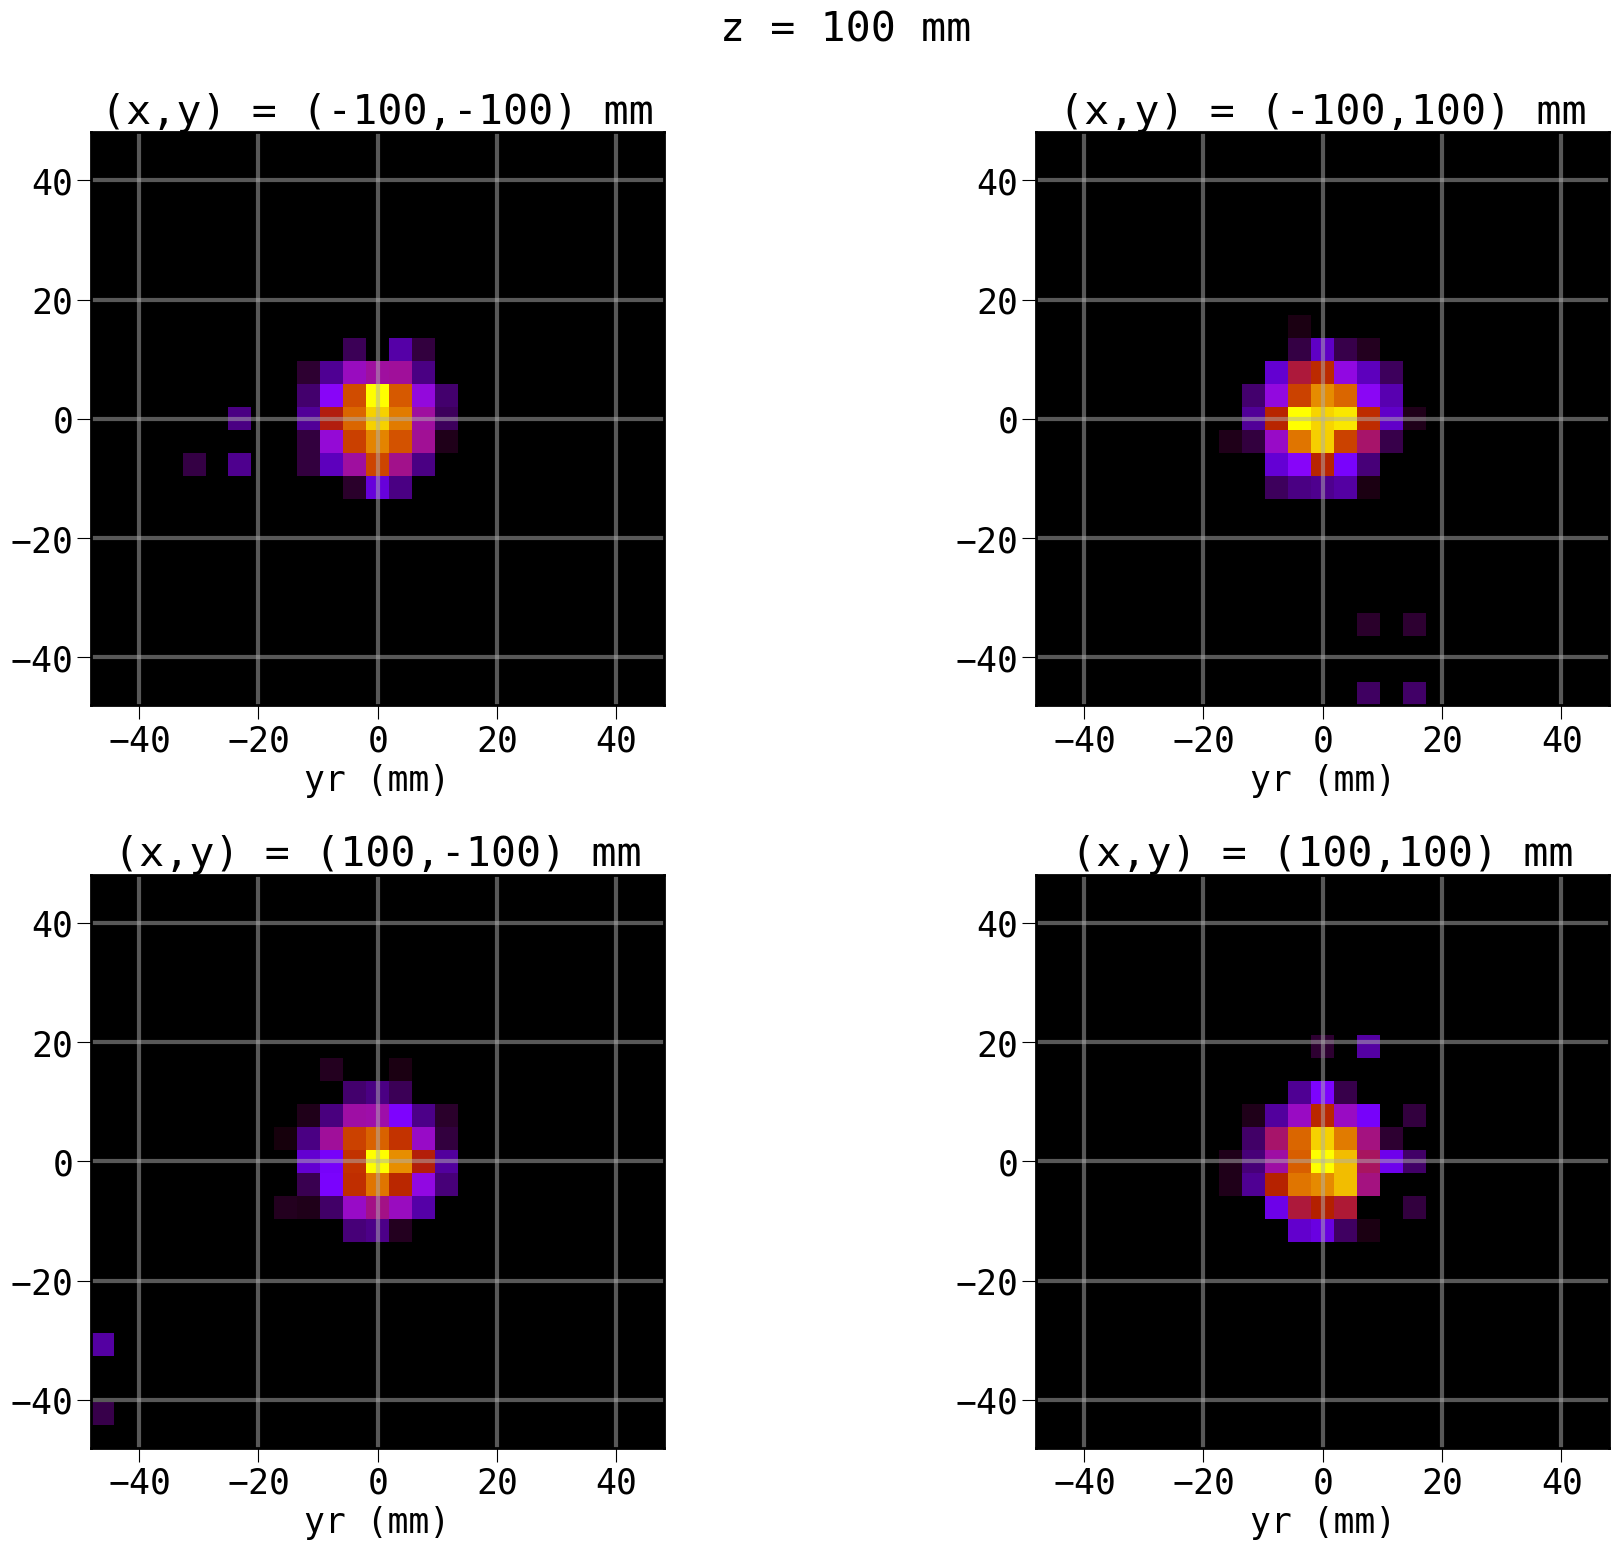

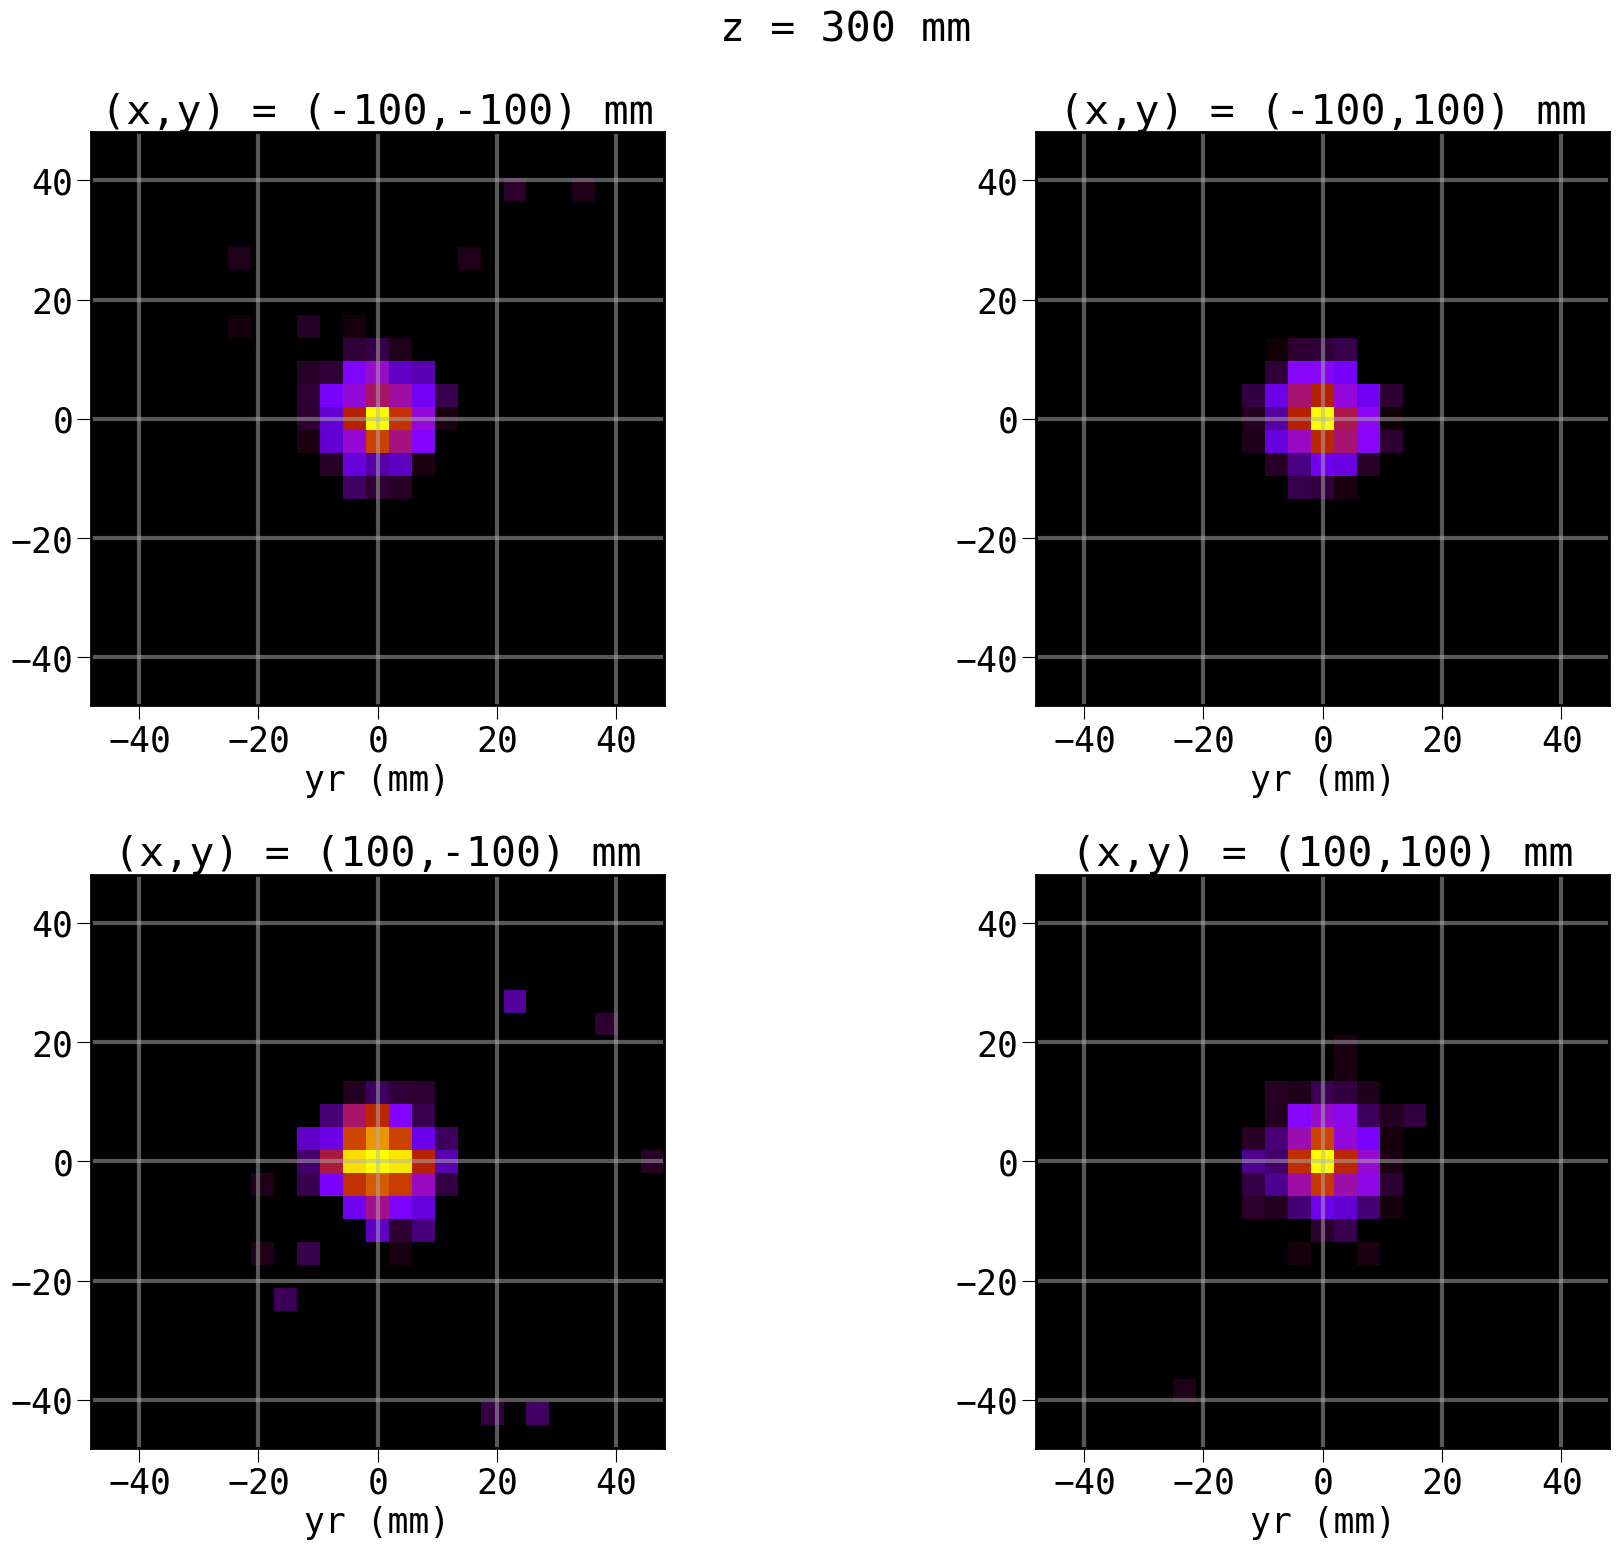

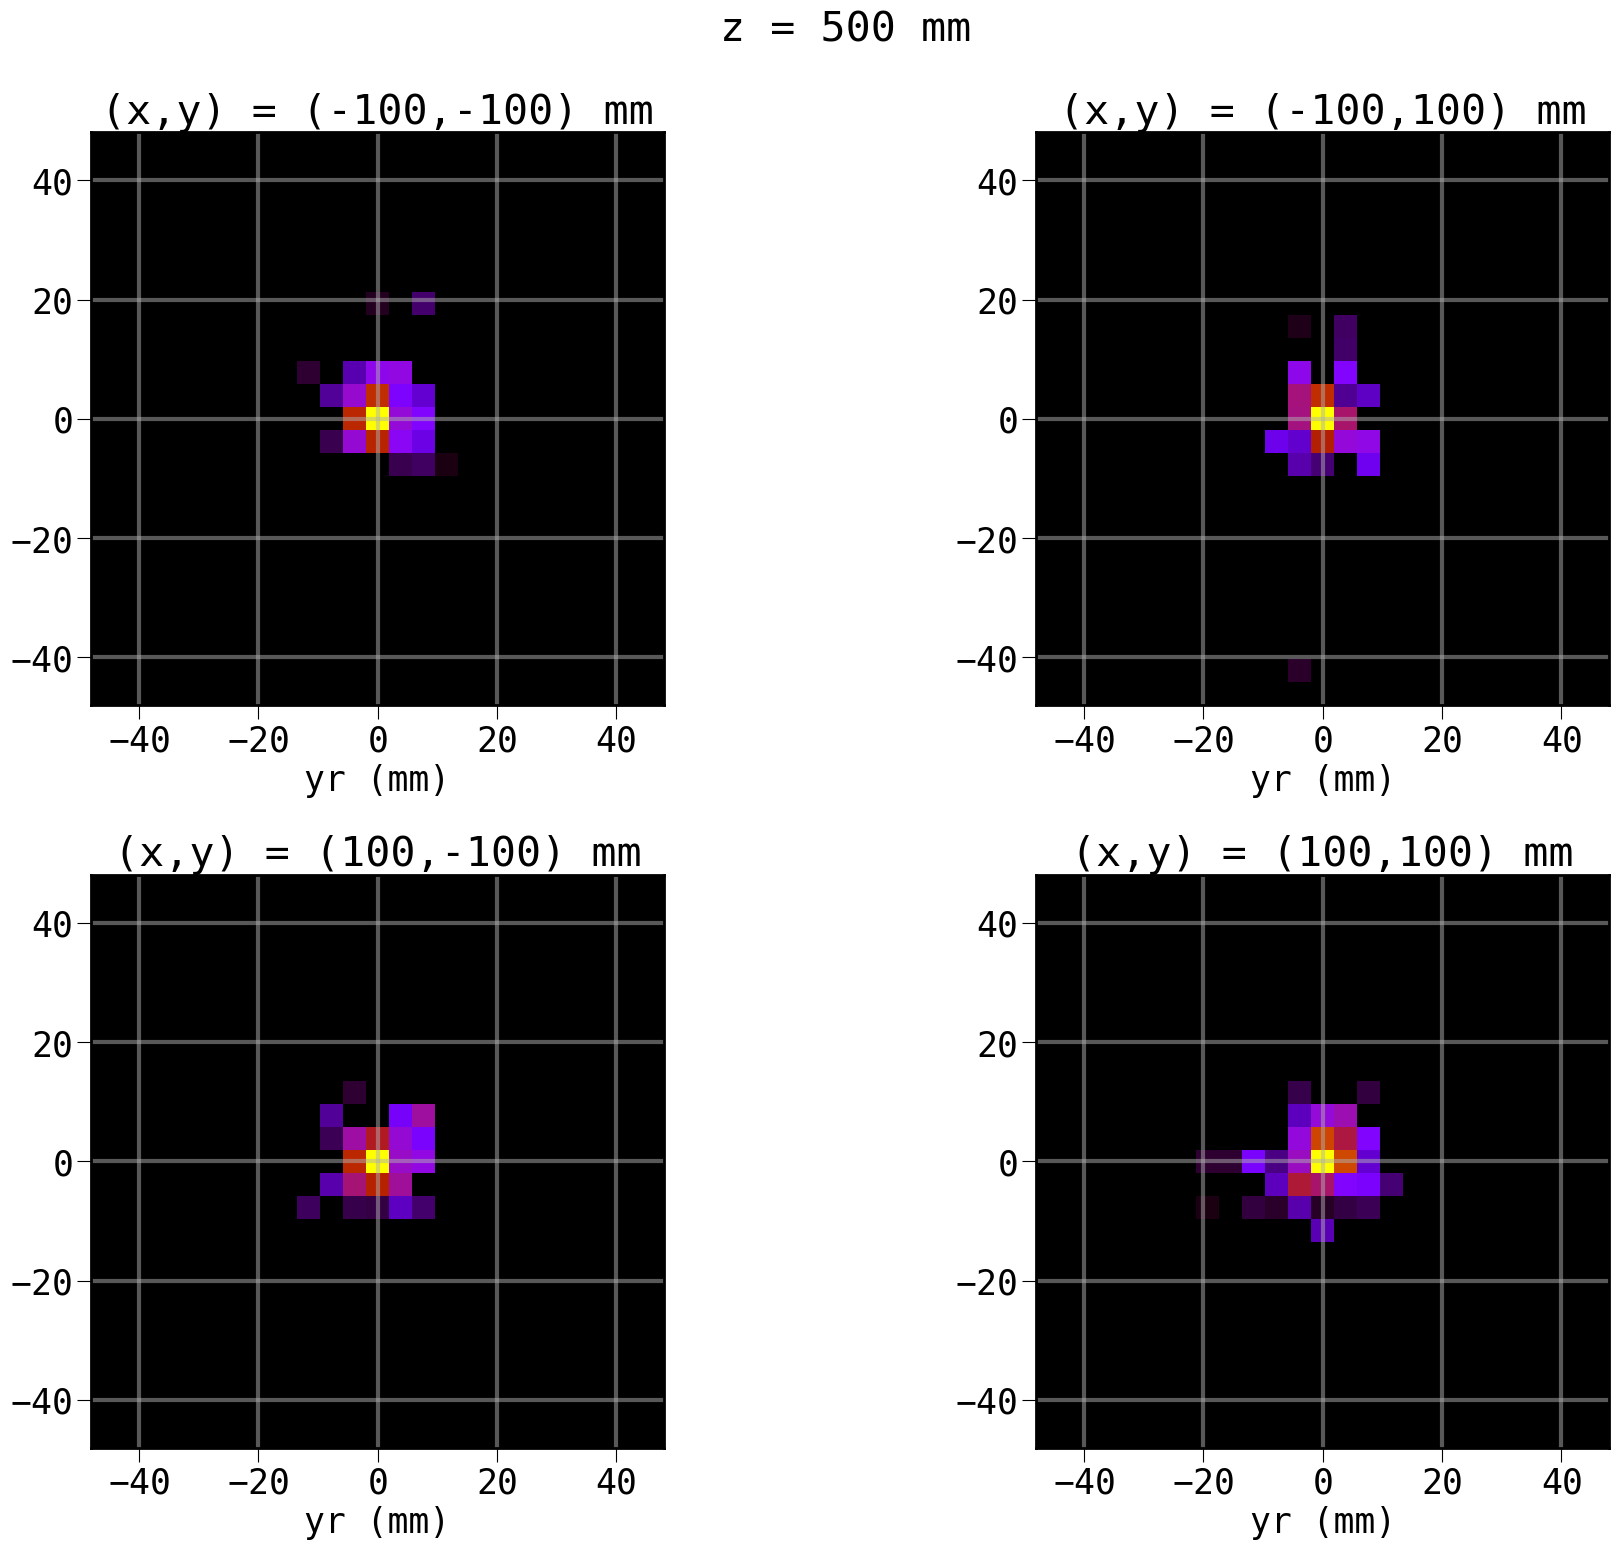

In [13]:
for z, zpsf in psfs.groupby("z"):
    plt.figure(figsize=(20, 16))
    k = 1
    for (x,y), psf in zpsf.groupby("x y".split()):
        nx = psf.xr.unique().size
        ny = psf.yr.unique().size
        matrix  = psf.factor.values.reshape(nx, ny)
        xyrange = (psf.xr.min(), psf.xr.max())
        plt.subplot(2, 2, k); k+=1
        plt.imshow(matrix, extent=(*xyrange, *xyrange), origin="lower", aspect="equal")
        plt.xlabel("xr (mm)")
        plt.xlabel("yr (mm)")
        plt.title(f"(x,y) = ({x:.0f},{y:.0f}) mm")
    plt.suptitle(f"z = {z:.0f} mm")

### 1D

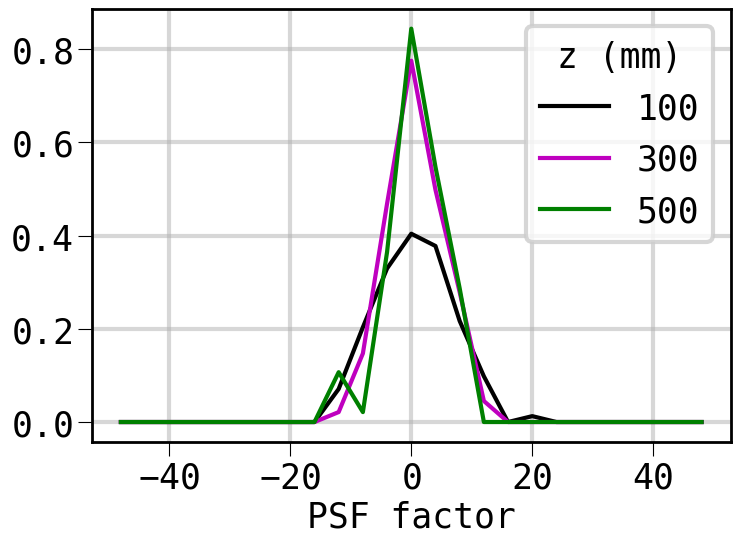

In [14]:
xypsf = psfs.loc[lambda df: (df.x == 100) & (df.y == 100)]
alongx = xypsf.loc[lambda df: df.yr==0]
for z, zpsf in alongx.groupby("z"):
    plt.plot(zpsf.xr, zpsf.factor, label=f"{z:.0f}")

plt.xlabel("xr (mm)")
plt.xlabel("PSF factor")
plt.legend(title="z (mm)")


## Now with a proper PSF...

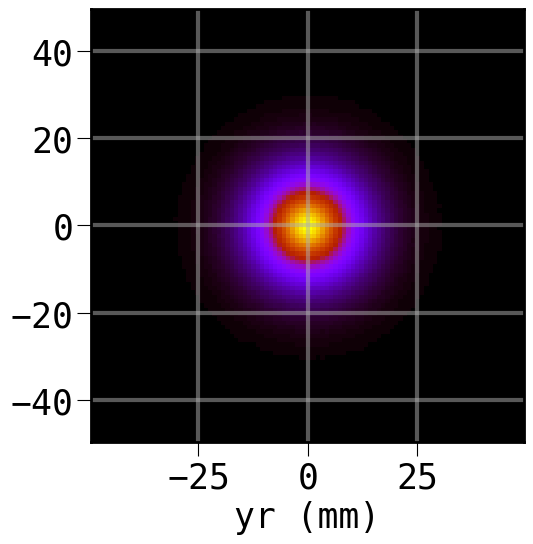

/home/gonzalo/sw/anaconda3/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


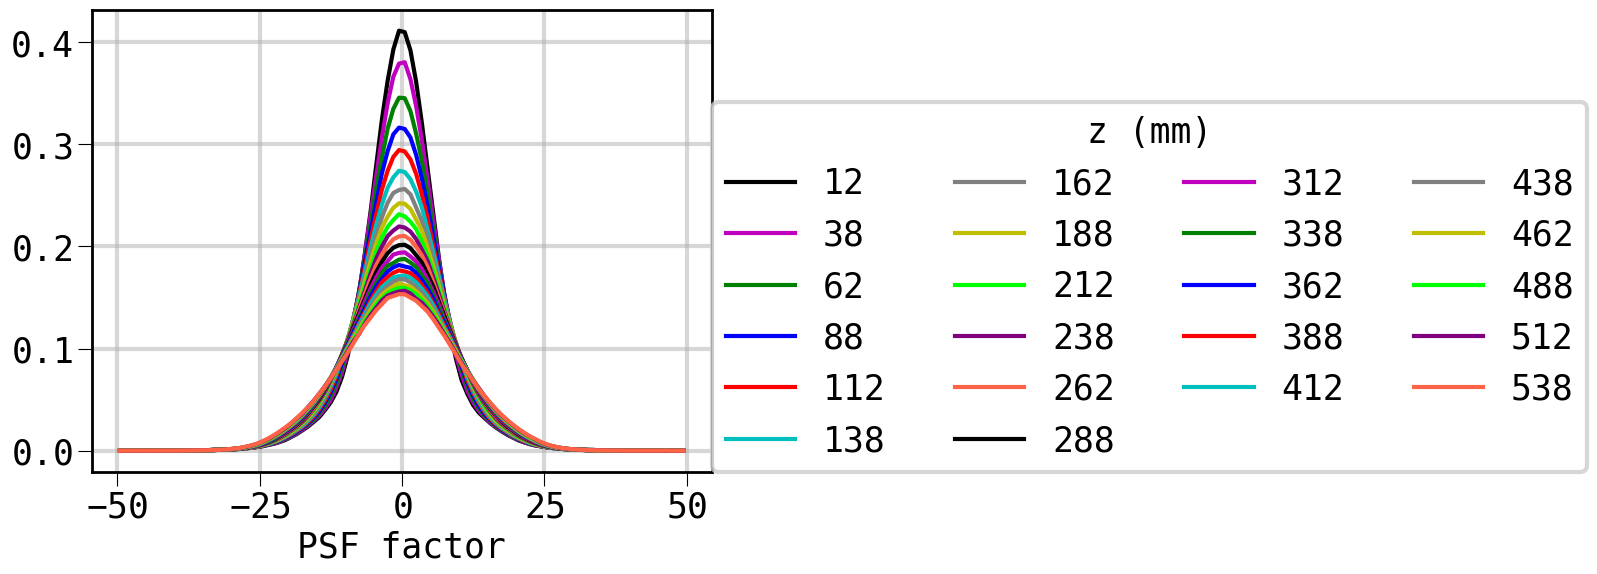

In [15]:
psfs = pd.read_hdf("maps/new.psf", "/PSF/PSFs")

plt.figure()
psf = psfs.loc[lambda df: df.z == 112.5]
nx = psf.xr.unique().size
ny = psf.yr.unique().size
matrix  = psf.factor.values.reshape(nx, ny)
xyrange = (psf.xr.min(), psf.xr.max())
plt.imshow(matrix, extent=(*xyrange, *xyrange), origin="lower", aspect="equal")
plt.xlabel("xr (mm)")
plt.xlabel("yr (mm)")
    
plt.figure()
alongx = psfs.loc[lambda df: df.yr==0.5]
for z, zpsf in alongx.groupby("z"):
    plt.plot(zpsf.xr, zpsf.factor, label=f"{z:.0f}")

plt.xlabel("xr (mm)")
plt.xlabel("PSF factor")
plt.legend(title="z (mm)", ncol=4, loc=(1,0))


# Notes